## Import All the Necessary Modules ##
### Auxiliary Imports ###

In [1]:
import matplotlib.pyplot as plt

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

import sklearn.datasets
import sklearn.preprocessing
import sklearn.tree

%matplotlib inline

### FAT Forensics Imports ###

In [2]:
import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.data.augmentation as fatf_augmentation
import fatf.utils.data.discretisation as fatf_discretisation
import fatf.utils.kernels as fatf_kernels
import fatf.utils.distances as fatf_distances

import fatf

20-Jan-29 11:27:03 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


### Prepare the Iris Data Set ###

We use the first two features of the Iris data set: 'sepal length (cm)' and 'sepal width (cm)', to facilitate 2-dimensional plotting of our experiments.

In [3]:
iris = fatf_datasets.load_iris()

iris_selected_features = [0, 1]

iris_target = iris['target'].astype(np.int16)
iris_target_names = iris['target_names']

iris_data = iris['data'][:, iris_selected_features]
iris_feature_names = iris['feature_names'][iris_selected_features]

print('Used feature names: {}.'.format(' and '.join(iris_feature_names)))

Used feature names: sepal length (cm) and sepal width (cm).


### Train a Predictive Model ###
Train a scikit-learn *Random Forest Classifier* on the first two features of the Iris data set and print out the *training set* accuracy.

In [4]:
clf_iris = RandomForestClassifier(n_estimators=50)
clf_iris.fit(iris_data, iris_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [5]:
iris_training_predictions = clf_iris.predict(iris_data)

iris_training_accuracy = sklearn.metrics.accuracy_score(
    iris_target, iris_training_predictions)

print('Training set *accuracy*: {:.3}.'.format(iris_training_accuracy))

Training set *accuracy*: 0.927.


### Plot the Training Data Set and the Decision Boundaries ###

In [6]:
colours_points = [plt.cm.Set1(i) for i in range(3)]
colours_predictions = [plt.cm.Pastel1(i) for i in range(3)]

x_min = iris_data[:, 0].min() - 2.3
x_max = iris_data[:, 0].max() + 1

y_min = iris_data[:, 1].min() - 1
y_max = iris_data[:, 1].max() + 1

grid_step = 0.01
grid_xx, grid_yy = np.meshgrid(
    np.arange(x_min, x_max, grid_step),
    np.arange(y_min, y_max, grid_step))

grid_prediction = clf_iris.predict(
    np.c_[grid_xx.ravel(), grid_yy.ravel()])
grid_prediction = grid_prediction.reshape(grid_xx.shape)
grid_prediction = grid_prediction.astype(np.int16)

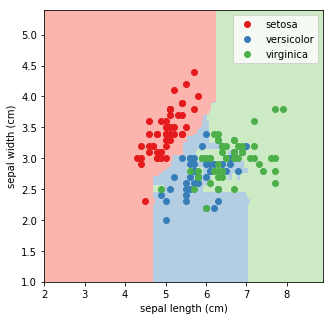

In [7]:
plt.figure(figsize=(5, 5))

plt.contourf(grid_xx, grid_yy, grid_prediction,
             levels=2, colors=colours_predictions)

for i in range(3):
    ix = np.where(iris_target == i)
    plt.scatter(iris_data[ix, 0], iris_data[ix, 1],
                label=iris_target_names[i],
                c=[colours_points[i]])

plt.xlabel(iris_feature_names[0])
plt.ylabel(iris_feature_names[1])
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

### Prepare the Sampling Algorithms ###

In [8]:
samplers_names = [
    'normal',
    'truncated_normal',
    'mixup',
    'normal_class_discovery'
]

samplers = [
    fatf_augmentation.NormalSampling(iris_data),
    fatf_augmentation.TruncatedNormalSampling(iris_data),
    fatf_augmentation.Mixup(iris_data, iris_target),
    fatf_augmentation.NormalClassDiscovery(
        iris_data, clf_iris.predict, classes_number=3,
        standard_deviation_init=0.20,
        standard_deviation_increment=0.10)
]

### Choose a Data Point and Sample Around It ###

In [9]:
data_point_index = 32
samples_number = 150

sampled_data = []
for sampler in samplers:
    sample = sampler.sample(
        iris_data[data_point_index, :],
        samples_number=samples_number)
    sampled_data.append(sample)

### Plot the Samples ###

Used sampler: normal.
Used sampler: truncated_normal.
Used sampler: mixup.
Used sampler: normal_class_discovery.


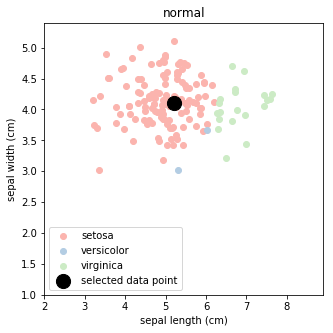

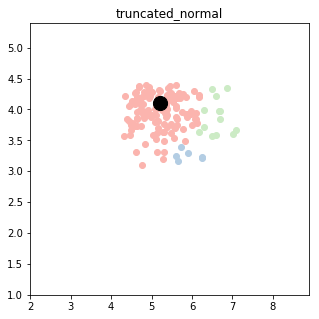

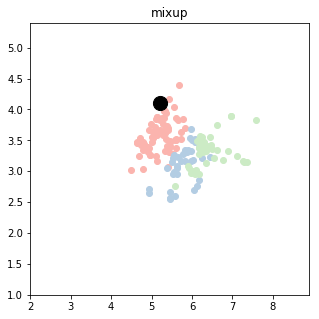

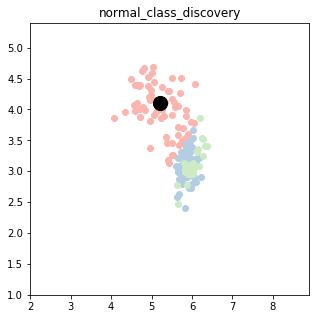

In [10]:
for i, name in enumerate(samplers_names):
    print('Used sampler: {}.'.format(name))
    
    plt.figure(figsize=(5, 5))
    
    plt.title(name)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    data = sampled_data[i]
    prediction = clf_iris.predict(data)
    
    for j in range(3):
        jx = np.where(prediction == j)
        
        # Only print the legend for the first figure
        label = iris_target_names[j] if not i else None
        plt.scatter(data[jx, 0], data[jx, 1], label=label,
                    c=[colours_predictions[j]])

    # Only print the legend for the first figure
    label = 'selected data point' if not i else None
    plt.scatter(iris_data[data_point_index][0],
                iris_data[data_point_index][1],
                c='k', s=200, label=label)
    # Only print the legend for the first figure
    if not i:
        plt.xlabel(iris_feature_names[0])
        plt.ylabel(iris_feature_names[1])
        plt.legend()

### Select a Data Point to Be Explained ###

In [11]:
data_point = np.array([4.9, 2.5], dtype=np.float32)
data_point_target = 2

### Show where Data Point is Located ###

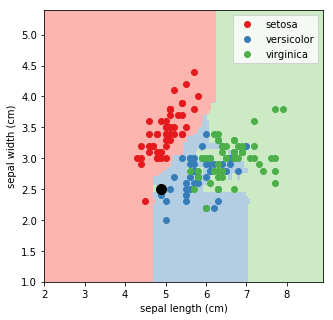

In [12]:
plt.figure(figsize=(5, 5))

plt.contourf(grid_xx, grid_yy, grid_prediction,
             levels=2, colors=colours_predictions)

for i in range(3):
    ix = np.where(iris_target == i)
    plt.scatter(iris_data[ix, 0], iris_data[ix, 1],
                label=iris_target_names[i],
                c=[colours_points[i]])

plt.scatter(data_point[0], data_point[1], c='k', s=100)
plt.xlabel(iris_feature_names[0])
plt.ylabel(iris_feature_names[1])
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

### Build Surrogates ###

In [13]:
local_samples_number = 1000

sampler = fatf_augmentation.NormalSampling(iris_data)

sampled_data = sampler.sample(data_point, samples_number=local_samples_number)

sampled_data_prediction = clf_iris.predict_proba(sampled_data)[:, data_point_target]

distance_normal = fatf_distances.euclidean_point_distance(data_point, sampled_data)

# Kernel width is set to the default value in the LIME implementation
kernel_width = 0.75 * np.sqrt(sampled_data.shape[1])
sampled_weights = fatf_kernels.exponential_kernel(distance_normal, width=kernel_width)

#### Linear Model (Ridge Regression) ####

In [14]:
ridge = Ridge(alpha=1, fit_intercept=True)
ridge.fit(sampled_data, sampled_data_prediction, sample_weight=sampled_weights)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [15]:
for feature, coef in zip(iris_feature_names, ridge.coef_.tolist()):
    print(feature + ': {:.2e}'.format(coef))

sepal length (cm): 8.29e-02
sepal width (cm): -2.70e-02


Text(0.5, 1.0, 'Original Dataset')

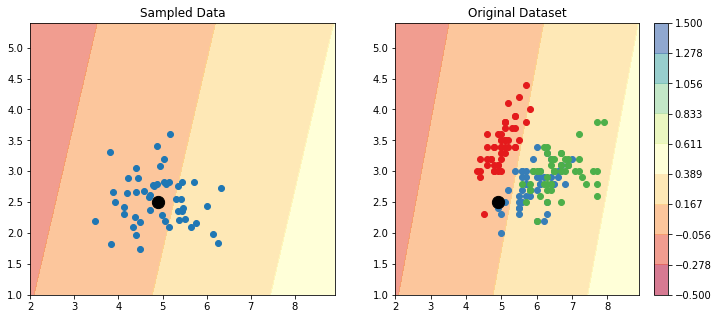

In [16]:
levels = np.linspace(-0.5, 1.5, 10)

ridge_prediction = ridge.predict(
    np.c_[grid_xx.ravel(), grid_yy.ravel()])   
ridge_prediction = ridge_prediction.reshape(grid_xx.shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cs = ax[0].contourf(grid_xx, grid_yy, ridge_prediction,
                  cmap=plt.cm.Spectral, alpha=0.6,
                  levels=levels)
cs = ax[1].contourf(grid_xx, grid_yy, ridge_prediction,
                  cmap=plt.cm.Spectral, alpha=0.6,
                  levels=levels)
cbar = plt.colorbar(cs)

ax[0].scatter(sampled_data[ix, 0], sampled_data[ix, 1])

for i in range(3):
    ix = np.where(iris_target == i)
    ax[1].scatter(iris_data[ix, 0], iris_data[ix, 1],
                label=iris_target_names[i],
                c=[colours_points[i]])

ax[0].scatter(data_point[0], data_point[1], c='k', s=150)
ax[1].scatter(data_point[0], data_point[1], c='k', s=150)

ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)

ax[0].set_title('Sampled Data')
ax[1].set_title('Original Dataset')

#### Surrogate Decision Tree ####

In [17]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(sampled_data, sampled_data_prediction, sample_weight=sampled_weights)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

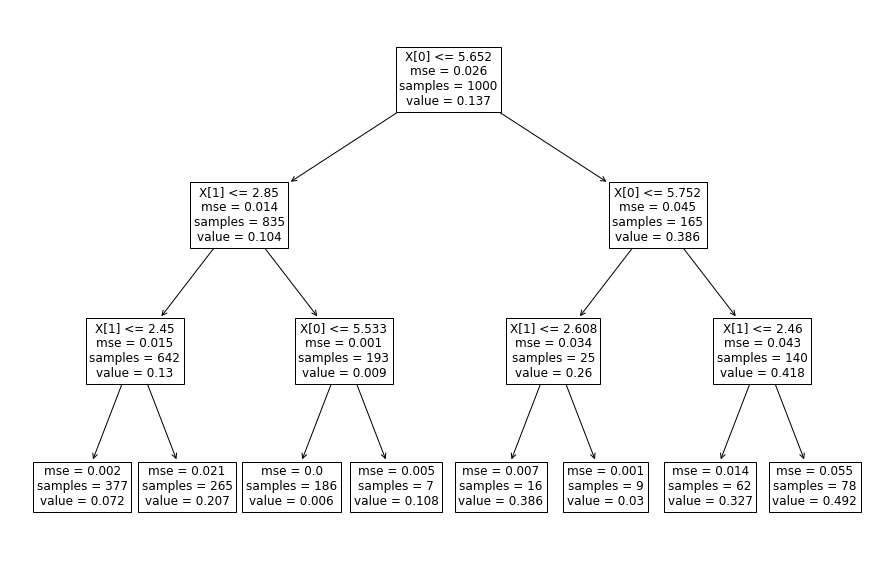

In [18]:
plt.figure(figsize=(15, 10))
tree_text = sklearn.tree.plot_tree(tree)

Text(0.5, 1.0, 'Original Dataset')

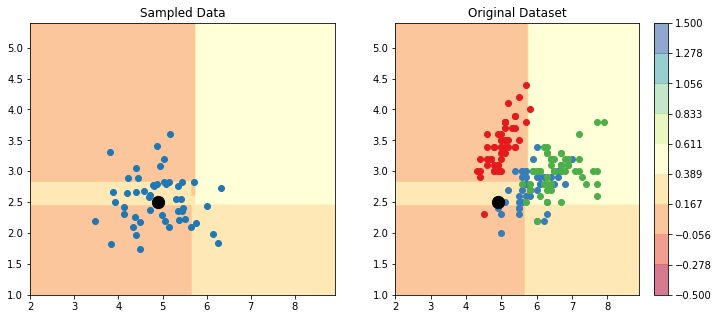

In [19]:
tree_prediction = tree.predict(
    np.c_[grid_xx.ravel(), grid_yy.ravel()])
tree_prediction = tree_prediction.reshape(
    grid_xx.shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

cs = ax[0].contourf(grid_xx, grid_yy, tree_prediction,
                  cmap=plt.cm.Spectral, alpha=0.6,
                  levels=levels)
cs = ax[1].contourf(grid_xx, grid_yy, tree_prediction,
                  cmap=plt.cm.Spectral, alpha=0.6,
                  levels=levels)
cbar = plt.colorbar(cs)

ax[0].scatter(sampled_data[ix, 0], sampled_data[ix, 1])

for i in range(3):
    ix = np.where(iris_target == i)
    ax[1].scatter(iris_data[ix, 0], iris_data[ix, 1],
                label=iris_target_names[i],
                c=[colours_points[i]])

ax[0].scatter(data_point[0], data_point[1], c='k', s=150)
ax[1].scatter(data_point[0], data_point[1], c='k', s=150)

ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[1].set_xlim(x_min, x_max)
ax[1].set_ylim(y_min, y_max)

ax[0].set_title('Sampled Data')
ax[1].set_title('Original Dataset')